# Derive and use gated likelihood

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
import multiprocessing
import os, datetime
from tqdm import tqdm
from numpy.fft import rfft, irfft
from scipy.linalg import circulant, toeplitz

from lisatools.diagnostic import *
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens, LISASens
from lisatools.utils.constants import *
from lisatools.detector import ESAOrbits, EqualArmlengthOrbits
from lisatools.datacontainer import DataResidualArray 
from lisatools.analysiscontainer import AnalysisContainer

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *
from few.trajectory.inspiral import EMRIInspiral
from few.utils.utility import get_p_at_t
from few.utils.fdutils import *
traj_module = EMRIInspiral(func="KerrEccEqFlux")

from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State
from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from eryn.backends import HDFBackend

from fastlisaresponse import pyResponseTDI, ResponseWrapper

try:
    import cupy as cp
except Exception:
    cp = None

In [2]:
# gpu
use_gpu = False

In [3]:
# metric
metric = "FastKerrEccentricEquatorialFlux"   # Kerr
traj = "KerrEccEqFlux"

In [4]:
# Observation parameters
#Tobs = 1  # [years]
#dt = 50.0  # [s]

Tobs = 0.006 # almost 2 days [yrs]
dt = 10.0  # [s]
eps = 1e-5  # mode content

emri_waveform_kwargs = dict(T=Tobs, dt=dt, eps=eps)

In [5]:
# Waveform parameters
M = 1e6  # central object mass
mu = 10  # secondary object mass
a = 0.5  # spin (will be ignored in Schwarzschild waveform)
#p0 = 8.2  # initial semi-latus rectum
p0 = 5.2  # initial semi-latus rectum
e0 = 0.5  # eccentricity
x0 = 1.0  # cosine of inclination 
dist = 1.0  # distance

qK = np.pi / 6  # polar spin angle (theta)
phiK = np.pi / 3  # azimuthal viewing angle
qS = np.pi / 6  # polar sky angle
phiS = np.pi / 3  # azimuthal viewing angle

Phi_phi0 = np.pi / 3
Phi_theta0 = np.pi / 6
Phi_r0 = np.pi / 3



emri_waveform_args = [
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

In [6]:
# TDI

tdi_chan="AE"
tdi_labels=["A", "E"]

#tdi_chan="AET"
#tdi_labels=["A", "E", "T"]

order = 25 # order of the langrangian interpolation (for strain and orbits?)

tdi_gen="1st generation"
#tdi_gen="2nd generation"


response_kwargs = dict(
        Tobs=Tobs,
        dt=dt,
        #t0 = 10000.0,  # time at which signal starts (chops off data at start and end of waveform)
        order = order, # order of the langrangian interpolation (for strain and orbits?)
        index_beta = 7,   # Sky location parameters: theta --> qS
        index_lambda = 8, #                          phi --> phiS
        tdi=tdi_gen, 
        tdi_chan=tdi_chan,
        orbits=EqualArmlengthOrbits(),
    )

Generate TD data with detector response

In [7]:
# Initialise generator
td_gen = GenerateEMRIWaveform(
        metric,
        sum_kwargs=dict(pad_output=True, odd_len=True),
        return_list=False,
        use_gpu=use_gpu,
    )



lisa_response = ResponseWrapper(waveform_gen=td_gen,
                                flip_hx=True,
                                use_gpu=use_gpu,
                                remove_sky_coords=False,
                                is_ecliptic_latitude=False,
                                remove_garbage=False,
                                **response_kwargs)




def fastlisaresponse(*params, emri_waveform_kwargs=None):
    return lisa_response(*params, **(emri_waveform_kwargs or {}))

#### Generate TD waveform

In [8]:
# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)
print(f"Waveform generation took {time.time()-start:.2f} s")

Waveform generation took 11.08 s


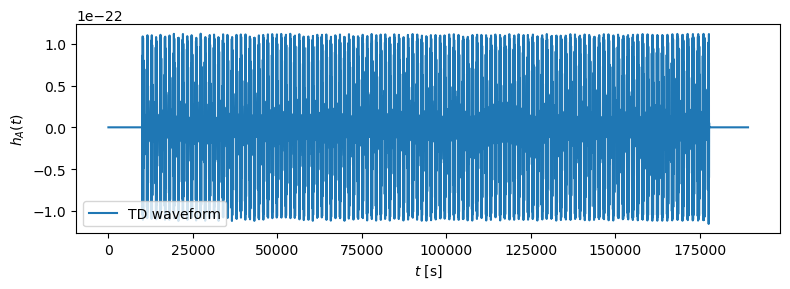

In [9]:
# Visualise the signal
time_array = np.arange(0,len(chans[0]))*dt

plt.figure(figsize=(8,3))
plt.plot(time_array, chans[0], label='TD waveform')
plt.ylabel(r'$h_{A}(t)$')
plt.xlabel(r'$t$ [s]')
#plt.xlim(1.7e5,1.9e5)
plt.legend()
plt.tight_layout()

plt.show()

#### Define w and W (gated function)

Choose positions of gaps: at 20%, 40%... of signal

In [10]:
N_d = 2*int(60*60/50)   # Length gap: 2 hrs
#N_d = 2*int(60*60*24/50)  # Length gap: 2 day

N_tot = len(chans[0])   # Tot lenght of signal

u = np.array([0.20, 0.40, 0.60, 0.80])  # position of gaps (after 20%, 40%... of signal)
# u = np.array([0.20, 0.45, 0.70, 0.95]) 

idx = np.floor(u * (N_tot - N_d) - 1).astype(int) # obtain the indeces of such positions

Create w: 0 where gaps, 1 where data

In [11]:
w = np.ones(N_tot, dtype=int)  
for i in idx: w[i:i+N_d] = 0     

Dataset with gaps obtained by multiplying the waveform by w (which sets the gap portions to zero)

In [12]:
chans_gap = chans * w

W diagonal matrix obtained by putting to zero the entries that correspond to gaps (= w as its diagonal)

In [13]:
W = np.diag(w)

Visualise signal with gaps

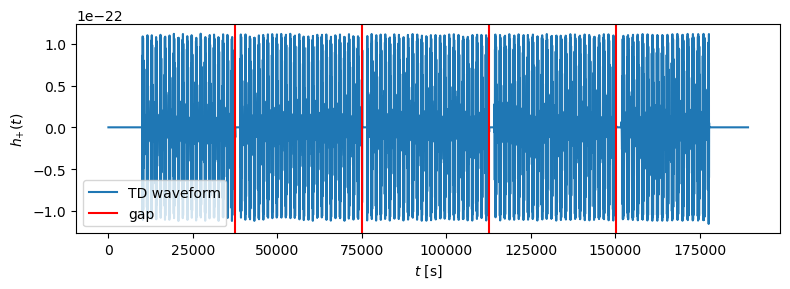

In [14]:
time_array = np.arange(0,len(chans_gap[0]))*dt

plt.figure(figsize=(8,3))
plt.plot(time_array, chans_gap[0], label='TD waveform')
plt.axvline(idx[0]*dt, color='r', label='gap')
plt.axvline(idx[1]*dt, color='r')
plt.axvline(idx[2]*dt, color='r')
plt.axvline(idx[3]*dt, color='r')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')
#plt.xlim(2.3e7,2.7e7)
plt.legend()
plt.tight_layout()

plt.show()

# TD likelihood 

### Compute pseudoinverse of gated covariance in TD

I'm doing everything for one channel (A). If it works, then I'll add also the second channel in the computation of the likelihood.

First, I compute the gated covariance matrix in TD for a Toeplitz process, as presented in Burke+(2025) paper.

In [15]:
def build_toeplitz_gated_sigma(psd_2N, w):
    """
    Builds the toeplitz matrix C (NxN) whose first row is the
    autocovariance function obtained from ifft(psd_samples).

    Args
    psd_samples : PSD samples corresponding to the frequency grid used by np.fft.ifft / np.fft.fftfreq.

    Returns
    C : Dense circulant matrix.
    acov : First autocovariance vector (real(ifft(psd_samples))).
"""
    psd_2N = np.asarray(psd_2N)
    L = psd_2N.size
    if L % 2 != 1: raise ValueError("PSD length must be 2N+1 (odd)")

    N = (L - 1) // 2

    # IDFT over length 2N+1
    acov_full = np.real(np.fft.ifft(psd_2N, n=L))

    # First N values
    acov = acov_full[:N]

    C = toeplitz(acov)


    if w is not None:
        w = np.asarray(w)
        if w.shape[0] != N: raise ValueError("w must have length N")
        # mask=True where it must be set to zero
        mask = (w == 0)
        # rows and columns are set to zero
        C[mask, :] = 0
        C[:, mask] = 0

    return C

First question: is it ok to consider my process (before adding gaps) as toeplitz? 
I think we did when we were using the Whittle likelihood.

In [16]:
# Sample the psd
N = len(chans[0])
freqs_2N = np.fft.fftfreq(2*N+1, d=dt)
Sn_2N = get_sensitivity(freqs_2N, sens_fn="A1TDISens")

Sigma = build_toeplitz_gated_sigma(Sn_2N, w)

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:633: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:635: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:637: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:642: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:644: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi * frq / C_SI) ** 2


In [17]:
print(Sigma)

[[264068.23523198 264068.23523198 264068.23523198 ... 264068.23523198
  264068.23523198 264068.23523198]
 [264068.23523198 264068.23523198 264068.23523198 ... 264068.23523198
  264068.23523198 264068.23523198]
 [264068.23523198 264068.23523198 264068.23523198 ... 264068.23523198
  264068.23523198 264068.23523198]
 ...
 [264068.23523198 264068.23523198 264068.23523198 ... 264068.23523198
  264068.23523198 264068.23523198]
 [264068.23523198 264068.23523198 264068.23523198 ... 264068.23523198
  264068.23523198 264068.23523198]
 [264068.23523198 264068.23523198 264068.23523198 ... 264068.23523198
  264068.23523198 264068.23523198]]


Second question: should the PSD be computed for all frequencies or only for positive frequencies?

In [ ]:
# Compute the pseudoinverse using the numpy function
pinv_computation = True

pinv_filename = "pinv_Sigma_TD.npy"

if pinv_computation:
    # Compute pseudoinverse
    start = time.time()
    pinv_Sigma = np.linalg.pinv(Sigma)
    print(f"Pseudoinverse computation took {time.time()-start:.2f} s")
    
    # Save result
    np.save(pinv_filename, pinv_Sigma)
    print(f"Pseudoinverse saved to {pinv_filename}")
else:
    # Load pseudoinverse from file
    print(f"Loading pseudoinverse from {pinv_filename}")
    pinv_Sigma_filt_compl = np.load(pinv_filename)
    print(f"Pseudoinverse loaded successfully")

Third question: are there any other options? This approach takes forever (at least more than 20min), because Sigma is very big.

In the paper: "The pseudo-inverse of the TD noise covariance matrix is simply the inverse of the individual block Toeplitz matrices as discussed in section III A".

I tried but I wasn't able to find any efficient way to identify each block and invert it. But anyway I expect my blocks to still be very big (especially for 1yr long signals), so I don't know if this might actually work.

Though, if this is the best way to proceed I'll try more.